In [1]:
!pip install torch
!pip install torchvision

In [2]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.4MB/s]


In [4]:
device=torch.device('cuda'if torch.cuda.is_available() else'cpu')
vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size)> max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transforms = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.5,),(0.5,))
  ])
  image = in_transforms(image).unsqueeze(0)
  return image

In [6]:
content = load_image('/kaggle/input/fotos-style-transfer/City.jpg').to(device)
style   = load_image('/kaggle/input/fotos-style-transfer/Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg',shape=content.shape[-2:]).to(device)


In [7]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

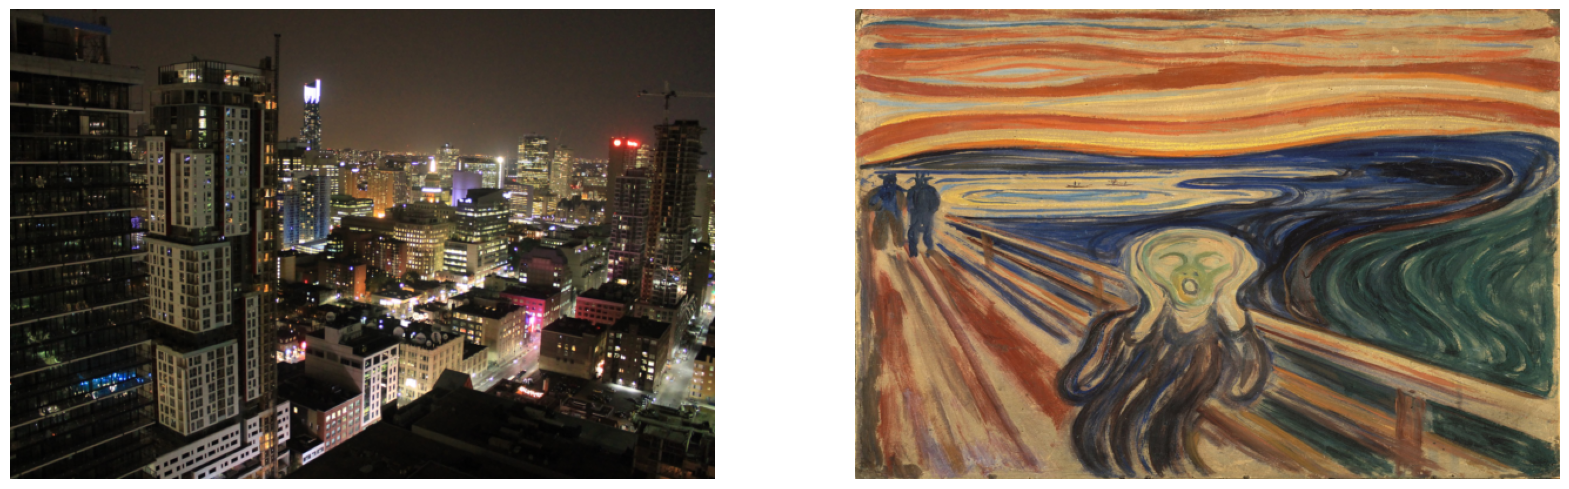

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off');

In [9]:
def get_features(image, model):
  layers = {'0':'conv1_1',
            '5':'conv2_1',
            '10':'conv3_1',
            '19':'conv4_1',
            '21':'conv4_2',#content extration
            '28':'conv5_1'}
  features ={}
  for name,layer in model._modules.items():
    image=layer(image)
    if name in layers:
      features[layers[name]]=image
  return features  

In [10]:
content_features=get_features(content,vgg)
style_features=get_features(style,vgg)

In [11]:
def gram_matrix(tensor):
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [12]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [13]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
 
content_weight = 1  # alpha
style_weight = 1e6  # beta
target = content.clone().requires_grad_(True).to(device)

In [14]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 3000
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  1153989.375
Iteration:  300


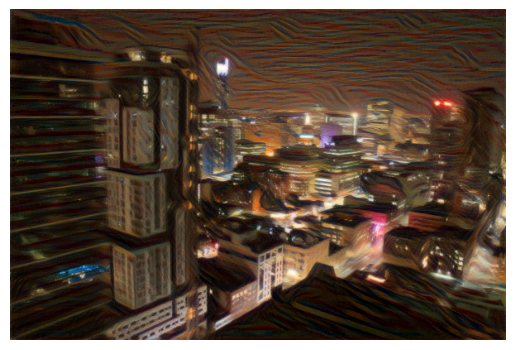

Total loss:  737952.5625
Iteration:  600


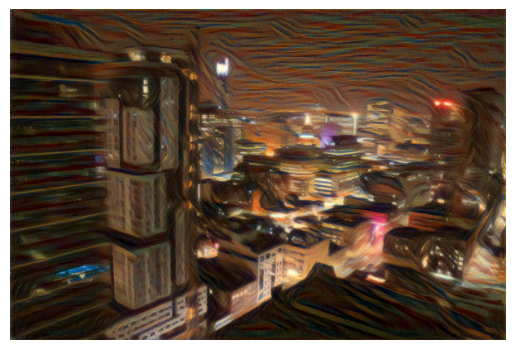

Total loss:  528025.375
Iteration:  900


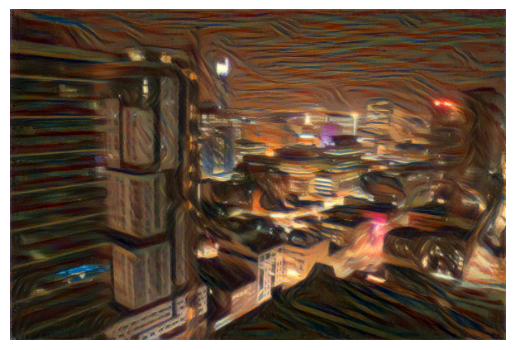

Total loss:  375181.90625
Iteration:  1200


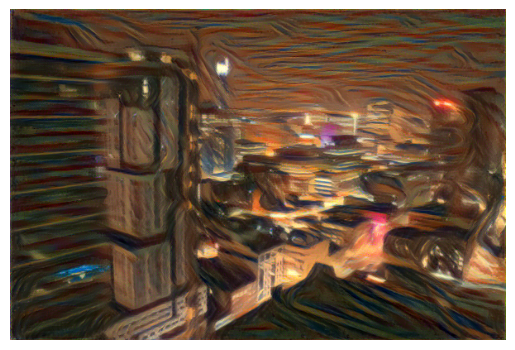

Total loss:  259994.203125
Iteration:  1500


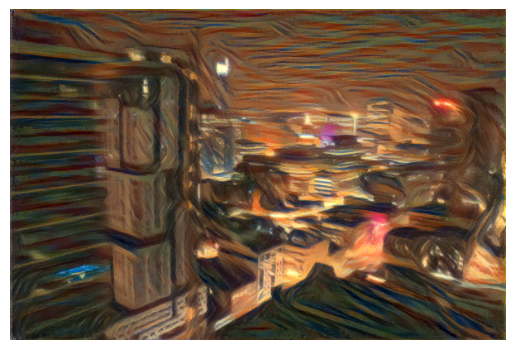

Total loss:  175801.5625
Iteration:  1800


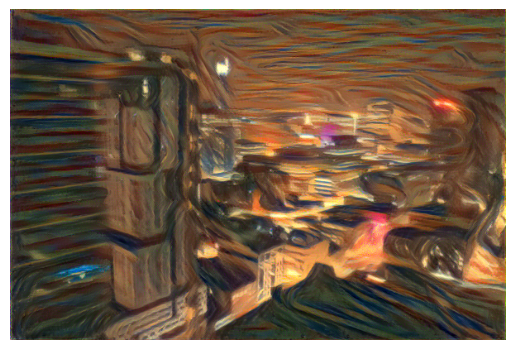

Total loss:  117086.21875
Iteration:  2100


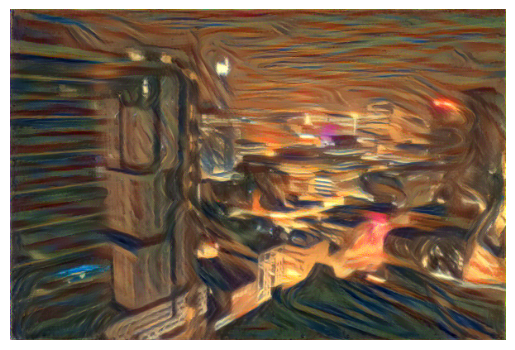

Total loss:  77782.6484375
Iteration:  2400


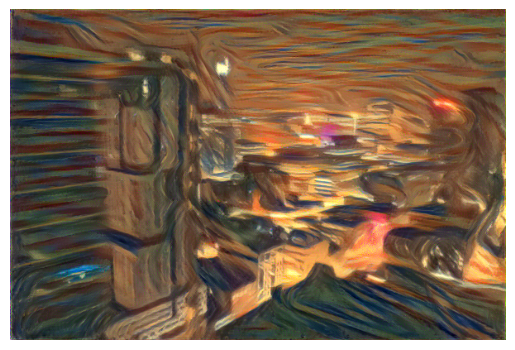

Total loss:  52287.2890625
Iteration:  2700


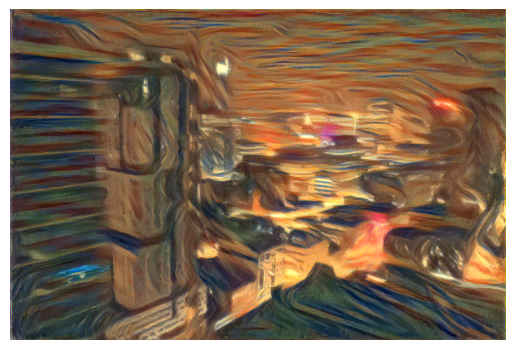

Total loss:  36133.8359375
Iteration:  3000


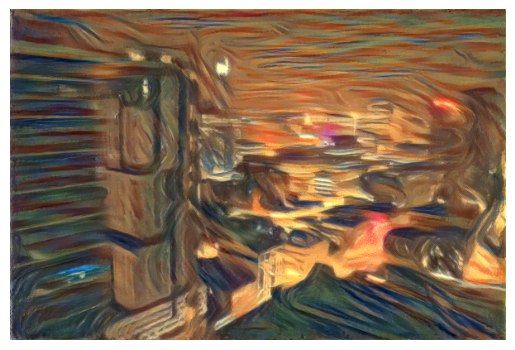

In [15]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

In [16]:
## transform in video## --not working very well
# import cv2 
 
# frame_height, frame_width, _ = im_convert(target).shape
# fourcc=cv2.VideoWriter_fourcc('F','M','P','4')
# vid = cv2.VideoWriter('output.mp4',fourcc, 30, (frame_width, frame_height))
 
# for i in range(300):
#   img = image_array[i]
#   img = img*255
#   img = np.array(img, dtype = np.uint8)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   vid.write(img)
 
# vid.release()


# from google.colab import files
# files.download('output.mp4')
